In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as spnorm
from CVO_support import downflow_lengths_new
%matplotlib inline

In [2]:
prefix = 'nomap_30m_spacing_xr1'

In [3]:
ventspacing = 2000 # in meters
saveeveryvent = False

In [4]:
def read_ARC_ASCII_HEADER(infile):
    with open(infile, 'r') as ifp:
        line = ifp.readline().strip().split()
        ncols = int(line[1])
        line = ifp.readline().strip().split()
        nrows = int(line[1])
        line = ifp.readline().strip().split()
        xllcorner = float(line[1])
        line = ifp.readline().strip().split()
        yllcorner = float(line[1])
        line = ifp.readline().strip().split()
        cellsize = float(line[1])
        line = ifp.readline().strip().split()
        NODATA_value = float(line[1])
        return nrows,ncols,xllcorner,yllcorner,cellsize,NODATA_value

In [5]:
nrows,ncols,xllcorner,yllcorner,kdecellsize,NODATA_value = read_ARC_ASCII_HEADER('kde_aniso_onlyeruption_mafic.txt')

In [6]:
kdex = np.arange((xllcorner+kdecellsize/2),((xllcorner+kdecellsize/2)+kdecellsize*(ncols-1)),kdecellsize)
kdey = np.arange(((yllcorner+kdecellsize*(nrows-1))-kdecellsize/2),(yllcorner+kdecellsize/2),-kdecellsize)
xventi_i = np.arange((xllcorner+kdecellsize/2),((xllcorner+kdecellsize/2)+kdecellsize*(ncols-1)),ventspacing)
yventi_i = np.arange(((yllcorner+kdecellsize*(nrows-1))-kdecellsize/2),(yllcorner+kdecellsize/2),-ventspacing)

In [7]:
kernel = np.loadtxt('kde_aniso_onlyeruption_mafic.txt', skiprows=6)

In [8]:
kernel[kernel==NODATA_value] = np.nan

In [9]:
plt.imshow(kernel, interpolation='nearest')
plt.colorbar()

### Crop to area of interest

In [10]:
cropx = np.array([5.66*10**5, 5.9*10**5])
cropy = np.array([2.68*10**6, 2.708*10**6])

In [11]:
# cast boolean to binary (1,0) by multiplying the conditional by 1
withinx = np.where((xventi_i>=cropx[0])*1+((xventi_i<=cropx[1])*1)==2)
xventi = xventi_i[withinx];
withiny = np.where(((yventi_i>=cropy[0])*1+(yventi_i<=cropy[1])*1)==2);
yventi = yventi_i[withiny]

### Load up the DEM

In [12]:
nrows,ncols,xllcorner,yllcorner,cellsize,NODATA_value = read_ARC_ASCII_HEADER('buffhaz_dem_30m_clip.txt')

In [13]:
xi = np.arange((xllcorner+cellsize/2), (xllcorner+cellsize/2)+cellsize*(ncols-1), cellsize)
yi = np.arange((yllcorner+cellsize*(nrows-1)-cellsize/2), (yllcorner+cellsize/2), -cellsize)

In [14]:
dem = np.loadtxt('buffhaz_dem_30m_clip.txt', skiprows=6)
dem[dem==NODATA_value] = np.nan

In [15]:
plt.imshow(dem, interpolation='nearest', cmap='viridis')
plt.colorbar()

# Select Grid of Vents

In [16]:
nventsi = len(xventi)*len(yventi);
ventsxi = np.zeros((nventsi));
ventsyi = np.zeros((nventsi));
ventsxi_index = np.zeros((nventsi));
ventsyi_index = np.zeros((nventsi));
vent_pi = np.zeros((nventsi));

In [17]:
ccount=0
ktol = 0.00005 # tolerance for whether kernel is active
maxxi = np.max(xi)
minxi = np.min(xi)
maxyi = np.max(yi)
minyi = np.min(yi)


for cx in xventi:
    for cy in yventi:
        ccount+=1
        kde_xi = np.argmin(np.abs(kdex-cx)) #find closest cell center
        kde_yi = np.argmin(np.abs(kdey-cy)) #find closest cell center
        insidekde = kernel[kde_yi,kde_xi] 
        insidedem = 1
        if cx>maxxi or cx<minxi or cy>maxyi or cy<minyi:
            insidedem -= 1
        else:
            dem_xi = np.argmin(np.abs(xi-cx))
            dem_yi = np.argmin(np.abs(yi-cy))

        if insidedem>0 and insidekde > ktol:
            ventsxi[ccount] = cx
            ventsyi[ccount] = cy
            ventsxi_index[ccount] = dem_xi;
            ventsyi_index[ccount] = dem_yi;
            vent_pi[ccount] = insidekde
            
            
ccount

168

# drop anything where x or y is zero

In [18]:
keep_inds=np.where(ventsxi*ventsyi != 0) # multiplying will make array zero if either coordinate == 0


In [19]:
ventsx = ventsxi[keep_inds].astype(int)
ventsy = ventsyi[keep_inds].astype(int)
ventsx_index = ventsxi_index[keep_inds].astype(int)
ventsy_index = ventsyi_index[keep_inds].astype(int)
vent_p = vent_pi[keep_inds]

In [20]:
len(ventsx)

148

In [21]:
vents = np.vstack((ventsy_index,ventsx_index)).T
vents_val = np.vstack((ventsy,ventsx)).T

In [22]:
plt.plot(ventsx,ventsy,'.')

In [23]:
N=len(vents)
xr = 1 # 100 simulations for each vent
maxdist = 22000 # Flows stop at 22 km away from the vent
pathsteps = 1e6 # Iteration limit of 1 million steps

In [24]:
lengths = np.loadtxt('justbasaltlengths.csv')*1000 # read in and convert to meters


In [25]:
y = np.arange(0,np.ceil(np.max(lengths)),500)

In [26]:
lengths

array([  9110.,   2740.,   1890.,  20470.,  10930.,  15880.,  18360.,
         7070.,  11400.,   5230.,  16370.,  10550.,  12650.,  17040.,
         7160.,   9250.,  13470.,  22890.,  20200.,  16540.,   7080.,
         4730.,  16480.,   8160.,  27270.,  12640.,  15300.,   4870.,
        12580.,   9720.,  18260.,   4010.,   5560.,  10410.,   5730.,
        13340.,   4290.,  17260.,   4000.,  18310.,  24690.,  14670.,
        15970.,    190.,   5150.,   1690.,   2430.])

In [27]:
mu=np.mean(lengths)
sig = np.std(lengths)
#f = np.exp(-(y-mu)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi)) # Length distribution
f = spnorm.pdf(y,mu,sig) # use the built-in function from scipy
f /= f.sum() # need to renormalize the probabilities so that they sum to unity

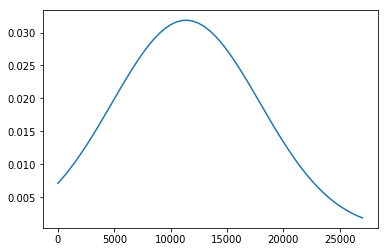

In [28]:
plt.plot(y,f)

In [29]:
totaltimes = np.zeros(N)

In [30]:
totalresults = np.zeros_like(dem)

In [31]:
if saveeveryvent: 
    savebyvent = np.zeros((dem.shape[0],dem.shape[1],N));

In [32]:
for ventn,(cinit,rinit) in enumerate(zip(ventsx_index,ventsy_index)):
    # by using enumerate, we get our counter for free (called "ventn" in this case)
    print ("rockin' sample {0} out of {1}".format(ventn, len(ventsx_index)))
    
    Lsample = np.random.choice(y, xr, p=f) # note that we can complete the discrete sample all in one step
    results, times = downflow_lengths_new(dem, xr, pathsteps,rinit,cinit,Lsample,cellsize);
    if saveeveryvent:
        savebyvent[:,:,ventn] = results
    
    totaltimes[ventn] = times
    # TO DO: Multiply by probability of vent opening and length!
    totalresults += (results*vent_p[ventn])
    

rockin' sample 0 out of 148
rockin' sample 1 out of 148
rockin' sample 2 out of 148
rockin' sample 3 out of 148
rockin' sample 4 out of 148
rockin' sample 5 out of 148
rockin' sample 6 out of 148
rockin' sample 7 out of 148
rockin' sample 8 out of 148
rockin' sample 9 out of 148
rockin' sample 10 out of 148
rockin' sample 11 out of 148
rockin' sample 12 out of 148
rockin' sample 13 out of 148
rockin' sample 14 out of 148
rockin' sample 15 out of 148
rockin' sample 16 out of 148
rockin' sample 17 out of 148
rockin' sample 18 out of 148
rockin' sample 19 out of 148
rockin' sample 20 out of 148
rockin' sample 21 out of 148
rockin' sample 22 out of 148
rockin' sample 23 out of 148
rockin' sample 24 out of 148
rockin' sample 25 out of 148
rockin' sample 26 out of 148
rockin' sample 27 out of 148
rockin' sample 28 out of 148
rockin' sample 29 out of 148
rockin' sample 30 out of 148
rockin' sample 31 out of 148
rockin' sample 32 out of 148
rockin' sample 33 out of 148
rockin' sample 34 out of

/Users/mnfienen/Documents/GIT/general_course/Menlo_Park_General/Hannah_example/CVO_support.py:42: RuntimeWarning: All-NaN axis encountered
  minelev = np.nanmin(elevs)


rockin' sample 114 out of 148
rockin' sample 115 out of 148
rockin' sample 116 out of 148
rockin' sample 117 out of 148
rockin' sample 118 out of 148
rockin' sample 119 out of 148
rockin' sample 120 out of 148
rockin' sample 121 out of 148
rockin' sample 122 out of 148
rockin' sample 123 out of 148
rockin' sample 124 out of 148
rockin' sample 125 out of 148
rockin' sample 126 out of 148
rockin' sample 127 out of 148
rockin' sample 128 out of 148
rockin' sample 129 out of 148
rockin' sample 130 out of 148
rockin' sample 131 out of 148
rockin' sample 132 out of 148
rockin' sample 133 out of 148
rockin' sample 134 out of 148
rockin' sample 135 out of 148
rockin' sample 136 out of 148
rockin' sample 137 out of 148
rockin' sample 138 out of 148
rockin' sample 139 out of 148
rockin' sample 140 out of 148
rockin' sample 141 out of 148
rockin' sample 142 out of 148
rockin' sample 143 out of 148
rockin' sample 144 out of 148
rockin' sample 145 out of 148
rockin' sample 146 out of 148
rockin' sa

In [33]:
plt.scatter(np.where(results==1)[0],np.where(results==1)[1])

In [34]:
results[results==0] = np.nan
plt.imshow(totalresults, cmap='viridis')
plt.colorbar()

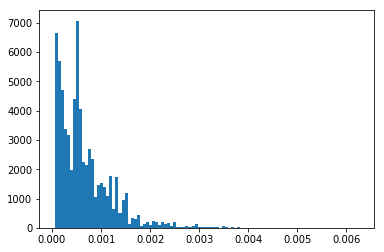

In [35]:
plt.hist(np.ravel(totalresults[totalresults>0]),bins=100);

# Compare with MATLAB Results

In [36]:
import h5py
inmat = h5py.File('results/test_for_Mike_2000_148_1.mat')

In [37]:
matresults = np.array(inmat['totalresults'])

In [38]:
plt.imshow(matresults.T, cmap='viridis')
plt.colorbar()

In [39]:
plt.hist(np.ravel(matresults[matresults>0]),bins=100);